In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import export_graphviz, plot_tree
from graphviz import Source,Digraph
from sklearn.tree import DecisionTreeClassifier

### Generator - creates dataset 
#### n_stages - number of nodes in graph
#### n_ways - number of nodes in one action
#### size - number of objects in log

In [3]:
class Generator():
    def __init__(self, n_stages=6,  n_ways=4, size=100):
        self.df = None        
        self.n_stages = n_stages
        self.n_ways = n_ways
        self.size = size
    
    def make_df(self):
        df_len = self.n_ways * self.size
        data = pd.DataFrame(np.arange(df_len), columns=['id'])
        data['stages'] = [0] * df_len
        ways = []
       
        # creating random ways
        while len(ways) != self.n_ways:
            way = [1] # start
            way_len = np.random.randint(2, self.n_stages)
            for _ in range(way_len):
                stage = np.random.randint(2, self.n_stages)
                way.append(stage)
            way.append(self.n_stages)
            way = pd.unique(way).tolist()
            if way not in ways and len(way) > 2:
                ways.append(way)                
        ways = np.repeat(ways, self.size)
        data['stages'] = ways            
        self.df = data
        return self    
    
    def make_features(self):
        data = self.df
        data = data.explode('stages')
        data['stages'] = data['stages'].astype(str)
        data['from'] = data.groupby(['id'])['stages'].shift(1)          
        edges = data.loc[:, ['from', "stages"]].drop_duplicates().dropna().values
        edges = [list(map(str, edge)) for edge in edges]                
        feature_cols = []
        i = 0
        for stage in data['stages'].unique():               
            transitions = list(filter(lambda x: stage in x[0], edges))
            if len(transitions) > 1:                
                stage_from = stage
                stages_to = [transition[1] for transition in transitions]

                train_mask = data['from'] == stage_from

                feat_name = 'X_{}'.format(i)
                for feat, stage_to in enumerate(stages_to):
                    mask = (data["stages"] == stage_to) & (data['from'] == stage_from)
                    data.loc[mask, feat_name] = (feat + 1) 
                    data.loc[mask, feat_name] += 1.1 * np.random.random(data.loc[mask, feat_name].shape[0]) - 0.55
                feature_cols.append(feat_name)
            i += 1
        data[data.columns[3:]] = data[data.columns[3:]].fillna(0)
        self.df = data
        return feature_cols, data        

In [4]:
G = Generator(1000)
G.make_df()

In [5]:
G.df.head()

,id,stages
0,0,"[1, 796, 436, 866, 193, 392, 359, 647, 739, 24..."
1,1,"[1, 796, 436, 866, 193, 392, 359, 647, 739, 24..."
2,2,"[1, 796, 436, 866, 193, 392, 359, 647, 739, 24..."
3,3,"[1, 796, 436, 866, 193, 392, 359, 647, 739, 24..."
4,4,"[1, 796, 436, 866, 193, 392, 359, 647, 739, 24..."


In [6]:
feature_cols, data = G.make_features()

KeyboardInterrupt: 

In [ ]:
data.head(10)

In [ ]:
data.shape

### what are these features 

In [8]:
feature_cols

['X_0',
 'X_1',
 'X_2',
 'X_3',
 'X_4',
 'X_5',
 'X_6',
 'X_7',
 'X_8',
 'X_9',
 'X_10',
 'X_11',
 'X_13',
 'X_14',
 'X_15',
 'X_16',
 'X_17',
 'X_18',
 'X_19',
 'X_20',
 'X_21',
 'X_22',
 'X_23',
 'X_24',
 'X_25',
 'X_26',
 'X_27',
 'X_28',
 'X_29',
 'X_30',
 'X_31',
 'X_32',
 'X_33',
 'X_34',
 'X_35',
 'X_36',
 'X_37',
 'X_38',
 'X_39',
 'X_40',
 'X_41',
 'X_42',
 'X_43',
 'X_44',
 'X_45',
 'X_46',
 'X_48',
 'X_49',
 'X_50',
 'X_51',
 'X_52',
 'X_53',
 'X_54',
 'X_57',
 'X_58',
 'X_59',
 'X_60',
 'X_61',
 'X_62',
 'X_63',
 'X_64',
 'X_65',
 'X_66',
 'X_67',
 'X_68',
 'X_69',
 'X_70',
 'X_71',
 'X_72',
 'X_73',
 'X_74',
 'X_75',
 'X_76',
 'X_77',
 'X_78',
 'X_79',
 'X_80',
 'X_81',
 'X_82',
 'X_83',
 'X_84',
 'X_85',
 'X_86',
 'X_87',
 'X_88',
 'X_89',
 'X_90',
 'X_91',
 'X_92',
 'X_94',
 'X_95',
 'X_96',
 'X_97',
 'X_98',
 'X_99',
 'X_100',
 'X_101',
 'X_102',
 'X_104',
 'X_105',
 'X_106',
 'X_108',
 'X_109',
 'X_111',
 'X_113',
 'X_114',
 'X_115',
 'X_116',
 'X_117',
 'X_118',
 'X_1

In [7]:
class RuleFinder():
    def __init__(self, df, id_col, stage_col, feature_cols):
        self.df = df
        self.id_col = id_col
        self.stage_col = stage_col
        self.feature_cols = feature_cols
        self.graph = None
        
    # creating graph with stages as nodes and ways as edges
    def create_graph(self):
        stages = self.df[self.stage_col].unique()
        graph = Digraph(comment='Process', format = 'pdf')
        for stage in stages:
            graph.node(str(stage))
        self.df['from'] = self.df.groupby([self.id_col])[self.stage_col].shift(1)
        edges = self.df.loc[:, ['from', self.stage_col]].drop_duplicates().dropna().values
        edges = [list(map(str, edge)) for edge in edges]
        graph.edges(edges)
        self.graph = graph
        return graph
    
    def _save_dot(self, trees):
        for num, tree in trees.items():
            if tree != None:
                export_graphviz(trees[num], out_file='tree{}.dot'.format(num),
                    feature_names=self.feature_cols,node_ids=True)
    
#     def _make_features(self):
#         feature_cols = []
#         i = 0
#         for stage in self.df[self.stage_col].unique():
#             transitions_str = list(filter(lambda x: '\t{} -> '.format(stage) in x, self.graph.body))
#             if len(transitions_str) > 1:
#                 feature_cols.append('X_{}'.format(i))
#                 self.df['X_{}'.format(i)] = np.zeros(shape=self.df.shape[0])
                
#                 transitions = list(map(lambda x: x.strip().split(" -> "), transitions_str))

#                 stage_from = stage
#                 stages_to = [transition[1] for transition in transitions]

#                 train_mask = self.df['from'] == stage_from

#                 for feat, stage_to in enumerate(stages_to):
#                     mask = (self.df[self.stage_col] == stage_to) & (self.df['from'] == stage_from)
#                     self.df.loc[mask, 'X_{}'.format(i)] = feat + 1
#                     self.df.loc[mask, 'X_{}'.format(i)] += 1.5*np.random.random(
#                         self.df.loc[mask, 'X_{}'.format(i)].shape[0]) -0.75
#                 i += 1
#         self.feature_cols = feature_cols
#         return self.df
    
    def compute_trees(self,min_impurity_decrease = 0.0015):
        trees = {}
        for stage in self.df[self.stage_col].unique():
            transitions_str = list(filter(lambda x: '\t{} -> '.format(stage) in x, self.graph.body))
            if len(transitions_str) > 1:
                transitions = list(map(lambda x: x.strip().split(" -> "), transitions_str))

                stage_from = stage
                stages_to = [transition[1] for transition in transitions]

                train_mask = self.df['from'] == stage_from

                for stage_to in stages_to:
                    mask = (self.df[self.stage_col] == stage_to) & (self.df['from'] == stage_from)
                    self.df.loc[mask, '_target_'] = stage_to

                X = self.df.loc[train_mask, self.feature_cols].values
                y = self.df.loc[train_mask, '_target_']
                
                min_class_ratio = 0.3 * np.min(y.value_counts()) / y.shape[0]
                tree = DecisionTreeClassifier(
                    min_samples_leaf=min_class_ratio, 
                    min_impurity_split=0.2, 
                    min_impurity_decrease=min_impurity_decrease)
                tree.fit(X, y)
                
                trees[stage] = tree
            else:
                trees[stage] = None
        self.df.drop('_target_', inplace=True, axis=1)
        
        self._save_dot(trees)
        return trees
    
    

In [10]:
data = pd.read_csv("30k.csv")
data.head()

,Unnamed: 0,id,stages,dt,user,user_id,stage_id
0,0,0.0,D,2020-01-01,user_4,4,3
1,1,0.0,A,2020-01-04,user_0,0,0
2,2,0.0,F,2020-01-09,user_0,0,5
3,0,1.0,A,2020-01-01,user_4,4,0
4,1,1.0,D,2020-01-02,user_4,4,3


In [17]:
feature_cols = ['user_id']

In [10]:
F = RuleFinder(data, 'id', 'stages', feature_cols)

In [12]:
F = RuleFinder(data, 'id', 'stages', ['user_id'])

In [14]:
%%time
graph = F.create_graph()

CPU times: user 13.6 ms, sys: 3.94 ms, total: 17.5 ms
Wall time: 16.4 ms


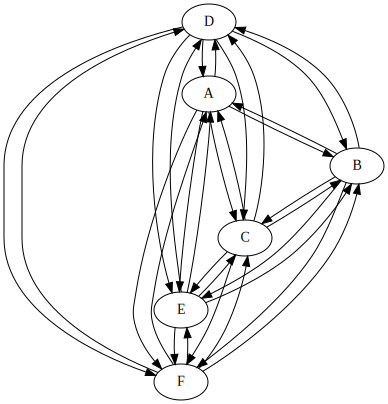

In [15]:
graph

In [ ]:
graph.body

graph.view()

In [ ]:
gen = Generator(n_stages=5, n_ways=10).make_df()
feature_cols, data = gen.make_features()

In [19]:
%%time
rule_finder = RuleFinder(data, 'id', 'stages', feature_cols)
graph = rule_finder.create_graph()
trees = rule_finder.compute_trees()

/home/ayd98/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ayd98/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ayd98/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ayd98/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:29

CPU times: user 386 ms, sys: 4 µs, total: 386 ms
Wall time: 383 ms


/home/ayd98/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ayd98/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)


In [ ]:
trees

In [ ]:
file = open('tree{}.dot'.format('2'), 'r')
text=file.read()
Source(text)

In [ ]:
graph.view()